In [1]:
!mkdir celeba
!unzip -qq /content/drive/MyDrive/data/Celeba/archive.zip -d celeba

In [2]:
!pip install transformers
!pip install adabelief-pytorch==0.2.0
!pip install ranger-adabelief==0.1.0

!pip install pytorch-lightning
!pip install comet-ml

     |████████████████████████████████| 2.1MB 8.3MB/s 
     |████████████████████████████████| 3.3MB 49.8MB/s 
     |████████████████████████████████| 901kB 54.6MB/s 
     |████████████████████████████████| 849kB 7.7MB/s 
     |████████████████████████████████| 276kB 16.2MB/s 
     |████████████████████████████████| 112kB 26.4MB/s 
     |████████████████████████████████| 184kB 20.9MB/s 
     |████████████████████████████████| 829kB 19.9MB/s 
     |████████████████████████████████| 1.3MB 36.1MB/s 
     |████████████████████████████████| 296kB 52.2MB/s 
     |████████████████████████████████| 143kB 51.0MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=468f607f595fc7b97bf3556f7a09388be5d8382b07836904a1fe67c0c6b67467
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=a4f85d46ac7acc437f62e4b69cf4a4

In [3]:
from dependency import *
from dataset import Dataset_CelebA
from model import Re_pl

class CheckpointEveryNSteps(pl.Callback):
    """
    Save a checkpoint every N steps, instead of Lightning's default that checkpoints
    based on validation loss.
    """

    def __init__(
        self,
        save_step_frequency,
        prefix="N-Step-Checkpoint",
        use_modelcheckpoint_filename=False,
        pathh = False,
    ):
        """
        Args:
            save_step_frequency: how often to save in steps
            prefix: add a prefix to the name, only used if
                use_modelcheckpoint_filename=False
            use_modelcheckpoint_filename: just use the ModelCheckpoint callback's
                default filename, don't use ours.
        """
        self.save_step_frequency = save_step_frequency
        self.prefix = prefix
        self.use_modelcheckpoint_filename = use_modelcheckpoint_filename
        self.pathh = pathh

    def on_batch_end(self, trainer: pl.Trainer, _):
        """ Check if we should save a checkpoint after every train batch """
        epoch = trainer.current_epoch
        global_step = trainer.global_step
        if global_step % self.save_step_frequency == 0:
            if self.use_modelcheckpoint_filename:
                filename = trainer.checkpoint_callback.filename
            else:
                filename = f"{self.prefix}_{epoch}_{global_step}.ckpt"
            ckpt_path = os.path.join(self.pathh, filename)
            print("we are here!!!")
            trainer.save_checkpoint(ckpt_path)

In [4]:
data_params = {
    "generalFolder": "/content/celeba/",
    "scale_im": (224, 224),
    "flip_chance": 0.5,
    "rotate_chance": 0.5,
    "batch_size": 64,
    "dataloader_shuffle": True,
    "num_workers": 2,
}

model_params = {
    "feature_out": 576,
    "output_size": 2*2,
    "classificator_dropout": 0.2,
}

learning_params = {
    "optimizer": "belief", # "belief", "ranger_belief", "adam", adamW
    "lr": 3e-4, #
    "eplison_belief": 1e-16,
    "beta": [0.9, 0.999], # not used
    "weight_decouple": True, 
    "weight_decay": 1e-4,
    "rectify": True,
    #
    "add_sch": False,
    #
    "epochs": 10, #

    "swa": True,
    "swa_start_epoch": 5, #35
    "swa_lr": 3e-5,
}


re_dict = {
    "model": model_params,
    "data_params": data_params,
    "training": learning_params,
}

In [5]:
root_dir = "/content/drive/MyDrive/data/weights"
naming = "eye_location4"

from datetime import datetime

comet_logger = CometLogger(
  save_dir='/content/log/',
    api_key="23CU99n7TeyZdPeegNDlQ5aHf",
    project_name="imageeye",
    workspace="etzelkut",
  # rest_api_key=os.environ["COMET_REST_KEY"], # Optional
  experiment_name = naming, # Optional
)

CometLogger will be initialized in online mode


In [ ]:
dataset_pl = Dataset_CelebA(re_dict["data_params"])
dataset_pl.prepare_data()
dataset_pl.setup()
steps_per_epoch = int(len(dataset_pl.train_dataloader()))
print(steps_per_epoch)

every_epoch = CheckpointEveryNSteps(save_step_frequency = steps_per_epoch, 
                                    use_modelcheckpoint_filename = False, 
                                    pathh=root_dir, prefix=naming+"N-Step-Checkpoint")


proj_a = Re_pl(re_dict, steps_per_epoch = steps_per_epoch)

trainer = Trainer(callbacks=[every_epoch],
                  resume_from_checkpoint='/content/drive/MyDrive/data/weights/eye_location4N-Step-Checkpoint_8_22800.ckpt', 
                  logger=comet_logger,
                  gpus=1,
                  profiler=True,
                  #auto_lr_find=True, #set hparams
                  #gradient_clip_val=0.5,
                  check_val_every_n_epoch=1,
                  #early_stop_callback=True,
                  #max_epochs = re_dict["training"]["epochs"],
                  progress_bar_refresh_rate = 0,
                  deterministic=True,)


# automatically restores model, epoch, step, LR schedulers, apex, etc...
trainer.fit(proj_a, dataset_pl)

checkpoint_name = os.path.join(root_dir, naming + '.ckpt')
trainer.save_checkpoint(checkpoint_name)
#copied with time for safety, not memory effec. but why bother I have infinite google drive
checkpoint_name = os.path.join(root_dir, naming + str(datetime.now()) + '.ckpt')
trainer.save_checkpoint(checkpoint_name)

In [ ]:
proj_a.change_for_swa(dataset_pl.train_dataloader())
checkpoint_name = os.path.join(root_dir, naming + '_swa.ckpt')
trainer.save_checkpoint(checkpoint_name)


In [ ]:
#seed_v = 42
#seed_everything(seed_v)

root_dir = "/content/drive/MyDrive/data/weights"
naming = "eye_location4"

every_epoch = CheckpointEveryNSteps(save_step_frequency = steps_per_epoch, 
                                    use_modelcheckpoint_filename = False, 
                                    pathh=root_dir, prefix=naming+"N-Step-Checkpoint")

from datetime import datetime

comet_logger = CometLogger(
  save_dir='/content/log/',
    api_key="23CU99n7TeyZdPeegNDlQ5aHf",
    project_name="imageeye",
    workspace="etzelkut",
  # rest_api_key=os.environ["COMET_REST_KEY"], # Optional
  experiment_name = naming, # Optional
)


#
dataset_pl = Dataset_CelebA(re_dict["data_params"])
dataset_pl.prepare_data()
dataset_pl.setup()
steps_per_epoch = int(len(dataset_pl.train_dataloader()))
print(steps_per_epoch)

proj_a = Re_pl(re_dict, steps_per_epoch = steps_per_epoch)


trainer = Trainer(callbacks=[every_epoch],
                  logger=comet_logger,
                  gpus=1,
                  profiler=True,
                  #auto_lr_find=True, #set hparams
                  #gradient_clip_val=0.5,
                  check_val_every_n_epoch=1,
                  #early_stop_callback=True,
                  max_epochs = re_dict["training"]["epochs"],
                  progress_bar_refresh_rate = 0,
                  deterministic=True,)

#~
trainer.fit(proj_a, dataset_pl)


#trainer.test()
#if re_dict["training"]["swa"]:
#  proj_a.change_for_swa(dataset_pl.train_dataloader())
#  trainer.test() # will it work?
#.
checkpoint_name = os.path.join(root_dir, naming + '.ckpt')
trainer.save_checkpoint(checkpoint_name)
#copied with time for safety, not memory effec. but why bother I have infinite google drive
checkpoint_name = os.path.join(root_dir, naming + str(datetime.now()) + '.ckpt')
trainer.save_checkpoint(checkpoint_name)

In [ ]:
transform_test = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])

PATH = "/content/drive/MyDrive/data/weights/eye_location3N-Step-Checkpoint_4_11400.ckpt"  
#PATH = "/content/drive/MyDrive/data/weights/eye_location3N-Step-Checkpoint_3_8550.ckpt"
model = Re_pl.load_from_checkpoint(PATH)
model.freeze()
model.eval()

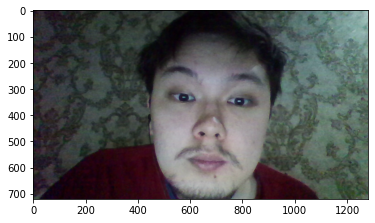

In [22]:
im = io.imread("/content/Photo-1-close.jpeg")
plt.imshow(im)

In [23]:
image = Image.fromarray(im)
image = transform_test(image)
lands = model(image[None])
lands

tensor([[-0.0838,  0.0131,  0.0829,  0.0068]])

In [24]:
new_lands = lands.view(2, 2)
new_lands = (new_lands+0.5).numpy() * np.array([[224, 224]])
new_lands

array([[ 93.22562504, 114.93257713],
       [130.56118584, 113.52182388]])

In [25]:
image = image.numpy().transpose((1, 2, 0))

In [26]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=50, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


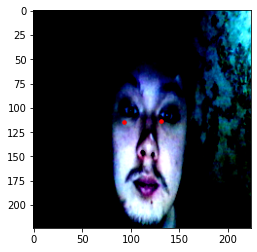

In [27]:
plt.figure()
show_landmarks(image, new_lands)
plt.show()